# Modelling a COPD ward

The simplest model using the data available to us is an $M|M|c$ queuing model. In this model, the following assumptions are made:

1. Interarrival and service times of patients are each exponential with some mean.
2. There are $c$ servers available to arriving patients at a single node representing the overall resource availability at the hospital.
3. There is no queue capacity.
4. A first-in first-out service policy is implemented.

### Choosing the distributions

#### Arrivals

Each group of patients has its own arrival distribution. The parameter of this distribution is taken to be the reciprocal of the mean interarrival times for that group.

#### Services (derived from responses)

Like arrivals, each group of patients has its own service time distribution. This will be calculated approximately via the length of a patient's stay. Technically, length of stay is the total time spent in the system, i.e. the response time. Without full details of process order and idle periods during a spell, we will consider the mean service time, $\frac{1}{\mu}$, to be proportional to the mean total system time, $\frac{1}{\phi}$, such that:

$$ \mu = p \phi $$

where $p \in (0, 1]$ is some parameter to be determined for each group.

### Determining parameters

As the full details of how the patients move through the hospital system, and the details of the system itself, are unknown, an appropriate number of servers $c$ must be found as well as $p$.

In order to estimate "good" values of each $p$ and the value of $c$, the system will be simulated using a number of parameter sets. Then the total time distribution will be compared with that in the available data via the (first) Wasserstein distance. This distance measures the approximate "minimal work" required to move between two probability distributions where "work" can be loosely defined as the product of how much of the distribution's mass must be to be moved with the distance it must be moved.

More formally, the Wasserstein distance between two probability distributions $U$ and $V$ is defined as:

$$ W(U, V) = \int_{0}^{1} \left\vert F^{-1}(t) - G^{-1}(t) \right\vert dt $$

where $F$ and $G$ are the CDFs of $U$ and $V$ respectively [[RGC15]](https://arxiv.org/abs/1509.02237).

Then the parameter set with the smallest mean distance over a number of runs is taken to be the most appropriate.

In [1]:
import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ciw.dists import Exponential
from scipy import stats

%matplotlib inline
plt.style.use("seaborn-colorblind")

In [2]:
copd = pd.read_csv(
    "../data/clusters/copd_clustered.csv",
    parse_dates=["admission_date"],
)

copd = copd.dropna(subset=["cluster"])

n_clusters = copd["cluster"].nunique()

## Getting a ballpark figure for parameters

In [3]:
def get_times(diff):

    times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)
    return times


def get_queue_params(data, prop, dist=stats.expon):
    """Get the arrival and service parameters from `data` and the given
    `prop`."""

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = np.mean(interarrival_times)

    mean_system_time = np.mean(data["true_los"])
    mu_estimate = mean_system_time * prop

    queue_params = {"arrival": 1 / lambda_, "service": 1 / mu_estimate}

    return queue_params


@dask.delayed
def run_single_class_trial(data, prop, num_servers, seed, max_time=365 * 4):

    ciw.seed(seed)
    queue_params = get_queue_params(data, prop)

    N = ciw.create_network(
        arrival_distributions=[Exponential(queue_params["arrival"])],
        service_distributions=[Exponential(queue_params["service"])],
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    records = Q.get_all_records()
    results = pd.DataFrame(
        [
            r
            for r in records
            if max_time * 0.25 < r.arrival_date < max_time * 0.75
        ]
    )

    results["system_time"] = results["exit_date"] - results["arrival_date"]
    results["service_prop"] = prop
    results["num_servers"] = num_servers
    results["seed"] = seed

    distance = stats.wasserstein_distance(
        results["system_time"], copd["true_los"]
    )
    results["distance"] = distance

    return results

In [4]:
# tasks = (
#     run_single_class_trial(copd, prop, num_servers, seed)
#     for prop, num_servers, seed in it.product(
#         np.arange(0.5, 1, 0.1), range(20, 61, 5), range(10)
#     )
# )

# with ProgressBar():
#     results = dask.compute(*tasks, scheduler="processes", num_workers=6)

In [5]:
# df = pd.concat(results)
# max_distances = df.groupby(["service_prop", "num_servers"])["distance"].max()

# prop, c = max_distances.idxmin()
# best = df[(df["service_prop"] == prop) & (df["num_servers"] == c)]

# prop, c, max_distances.min()

In [6]:
# fig, ax = plt.subplots(dpi=200)

# ax.hist(
#     copd["true_los"],
#     bins=50,
#     alpha=0.5,
#     density=True,
#     label="observed data",
# )
# ax.hist(
#     best["system_time"],
#     bins=50,
#     alpha=0.5,
#     density=True,
#     label="simulated data",
# )

# ax.set_xlabel("length of stay (days)")
# ax.set_ylabel("frequency density")

# ax.set_xlim(-5, 65)
# ax.legend()

In [7]:
df = pd.read_csv("../data/wasserstein/main.csv")
df.head()

,p_0,p_1,p_2,p_3,num_servers,seed,distance
0,0.5,0.5,0.5,0.5,30,0,2.912702
1,0.5,0.5,0.5,0.5,30,1,2.949490
2,0.5,0.5,0.5,0.5,30,2,3.111435
3,0.5,0.5,0.5,0.5,30,3,2.784079
4,0.5,0.5,0.5,0.5,30,4,2.936948


### Best and worst cases

In [8]:
with open("../data/wasserstein/best/params.txt", "r") as f:
    params = list(map(float, f.read().split(" ")))
    best_ps = params[:n_clusters]
    best_c = int(params[n_clusters])
    best_distance = params[-1]

best_ps, best_c, best_distance

([0.8000000000000003,
  1.0000000000000004,
  1.0000000000000004,
  0.8500000000000003],
 35,
 0.6808590701577519)

In [9]:
best_df = pd.read_csv("../data/wasserstein/best/main.csv")
best_df.head()

,id_number,customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,system_time
0,1371,1,1,366.370050,0.000000,366.370050,0.451341,366.821392,0.0,366.821392,-1,34,37,0.451341
1,1369,2,1,366.232570,0.000000,366.232570,0.765669,366.998239,0.0,366.998239,-1,32,37,0.765669
2,1375,2,1,366.813051,0.397815,367.210865,0.134218,367.345084,0.0,367.345084,-1,37,36,0.532033
3,1367,2,1,365.618228,0.000000,365.618228,1.896349,367.514577,0.0,367.514577,-1,31,36,1.896349
4,1374,1,1,366.728915,0.269323,366.998239,0.689331,367.687570,0.0,367.687570,-1,36,35,0.958655


In [10]:
histkw = {
    "bins": 100,
    "histtype": "step",
    "fill": True,
    "alpha": 0.5,
    "density": True,
}

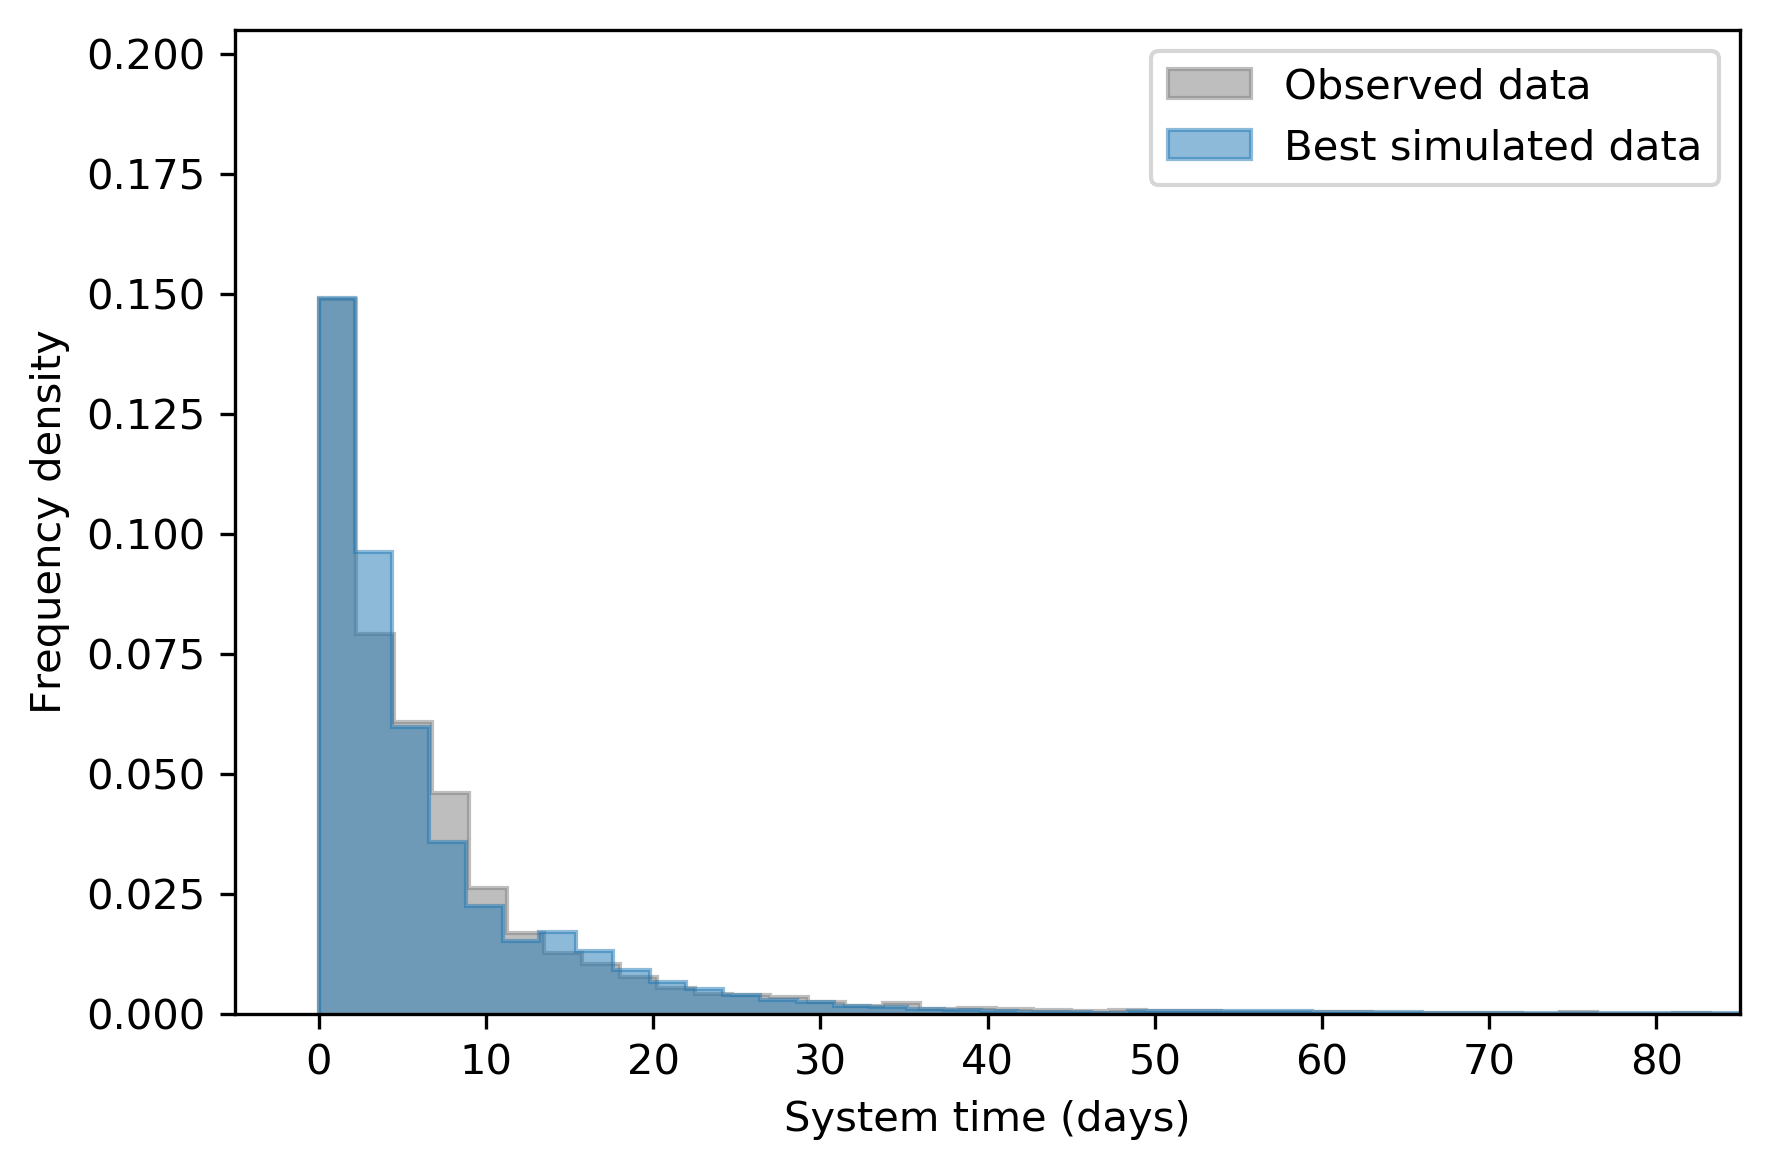

In [11]:
fig, ax = plt.subplots(dpi=300)

ax.hist(copd["true_los"], color="tab:gray", label="Observed data", **histkw)
ax.hist(
    best_df["system_time"],
    color="tab:blue",
    label="Best simulated data",
    **histkw,
)

ax.set(
    xlim=(-5, 85),
    ylim=(0, 0.205),
    xlabel="System time (days)",
    ylabel="Frequency density",
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/best_params.pdf", transparent=True)

In [12]:
with open("../data/wasserstein/median/params.txt", "r") as f:
    params = list(map(float, f.read().split(" ")))
    median_ps = params[:n_clusters]
    median_c = int(params[n_clusters])
    median_distance = params[-1]

median_ps, median_c, median_distance

([0.7000000000000002, 0.55, 0.8500000000000003, 0.7000000000000002],
 40,
 1.9524744730693282)

In [13]:
median_df = pd.read_csv("../data/wasserstein/median/main.csv")
median_df.head()

,id_number,customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,system_time
0,1355,2,1,366.017225,0.0,366.017225,0.139176,366.156401,0.0,366.156401,-1,17,17,0.139176
1,1353,2,1,365.518719,0.0,365.518719,1.895776,367.414494,0.0,367.414494,-1,16,22,1.895776
2,1357,2,1,366.182221,0.0,366.182221,3.616326,369.798546,0.0,369.798546,-1,17,23,3.616326
3,1354,2,1,365.991454,0.0,365.991454,4.222030,370.213484,0.0,370.213484,-1,16,25,4.222030
4,1371,2,1,370.158590,0.0,370.158590,0.238422,370.397012,0.0,370.397012,-1,25,25,0.238422


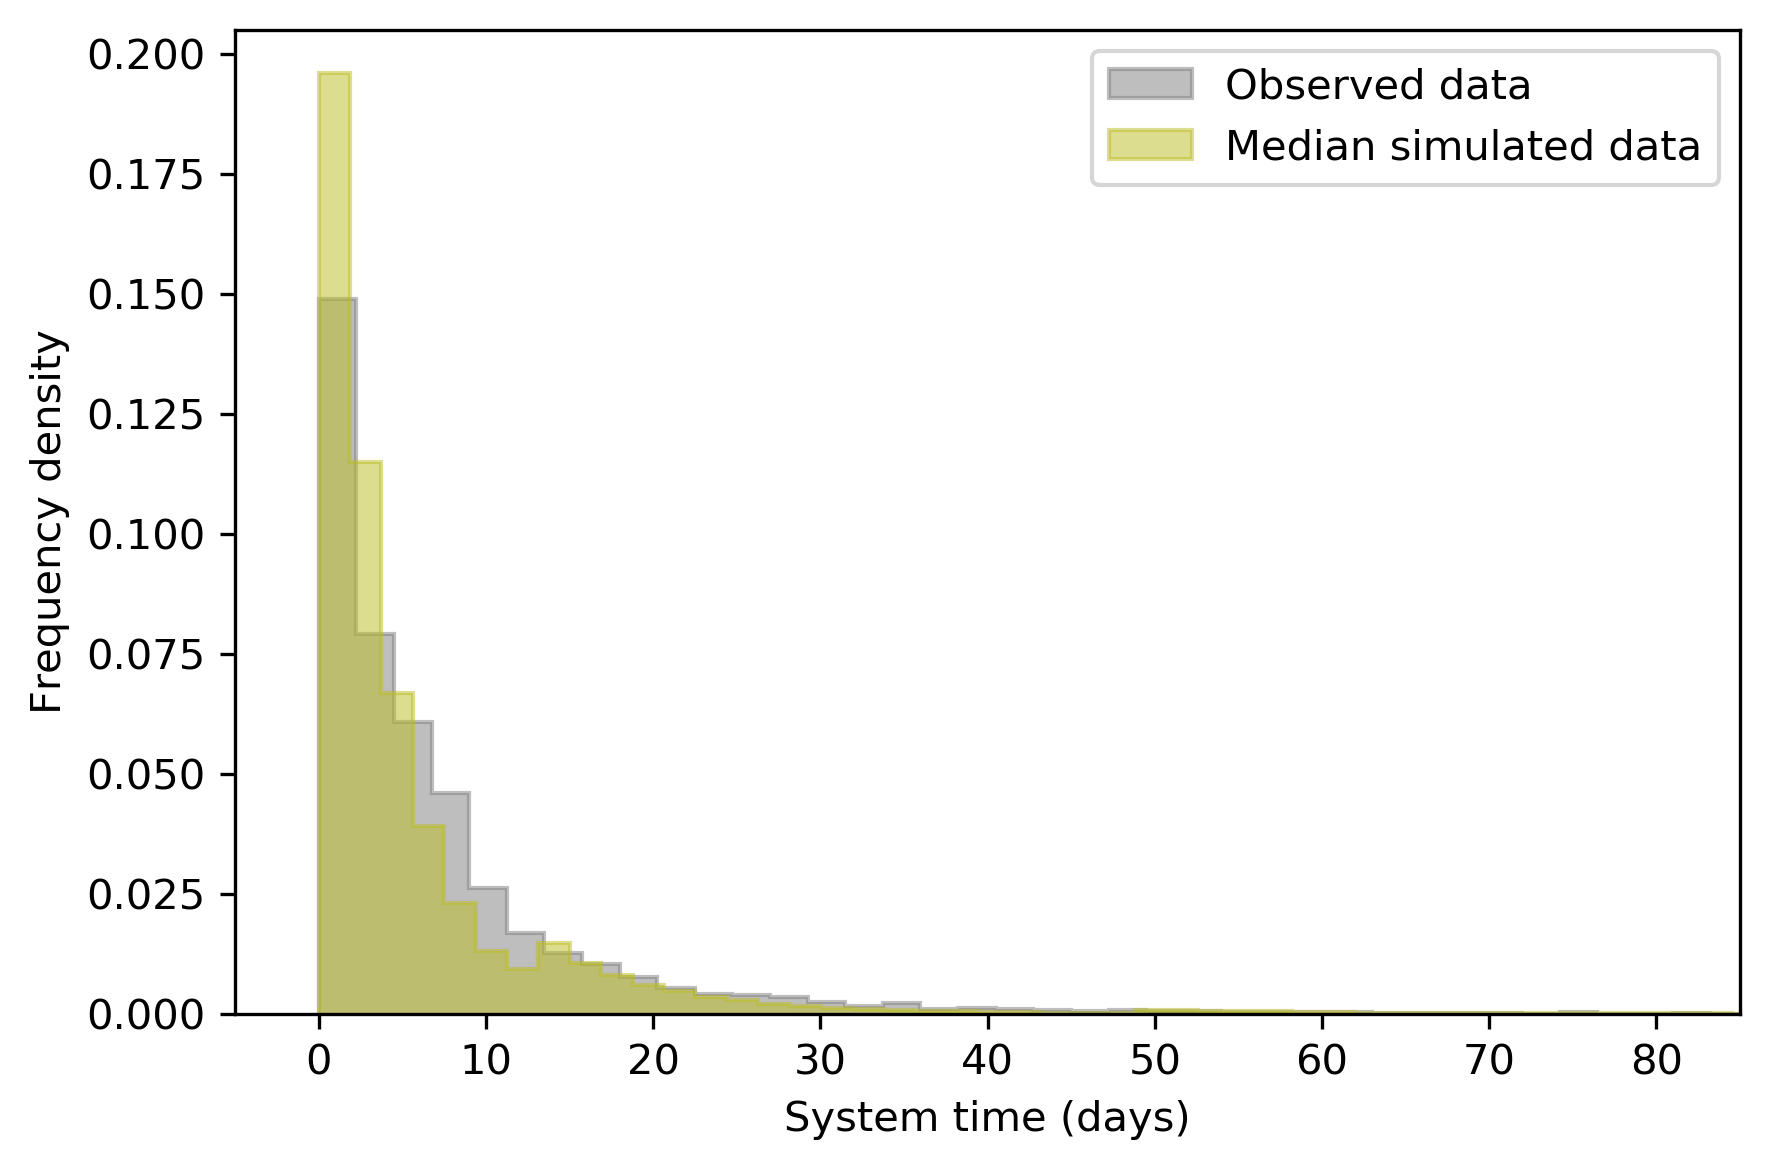

In [14]:
fig, ax = plt.subplots(dpi=300)

ax.hist(copd["true_los"], color="tab:gray", label="Observed data", **histkw)
ax.hist(
    median_df["system_time"],
    color="tab:olive",
    label="Median simulated data",
    **histkw,
)

ax.set(
    xlim=(-5, 85),
    ylim=(0, 0.205),
    xlabel="System time (days)",
    ylabel="Frequency density",
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/median_params.pdf", transparent=True)

In [15]:
with open("../data/wasserstein/worst/params.txt", "r") as f:
    params = list(map(float, f.read().split(" ")))
    worst_ps = params[:n_clusters]
    worst_c = int(params[n_clusters])
    worst_distance = params[-1]

worst_ps, worst_c, worst_distance

([1.0000000000000004,
  1.0000000000000004,
  0.9500000000000004,
  0.9000000000000004],
 30,
 44.25148592413545)

In [16]:
worst_df = pd.read_csv("../data/wasserstein/worst/main.csv")
worst_df.head()

,id_number,customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,system_time
0,1348,2,1,366.225140,0.0,366.225140,0.320606,366.545747,0.0,366.545747,-1,23,22,0.320606
1,1355,2,1,367.805696,0.0,367.805696,0.155468,367.961165,0.0,367.961165,-1,25,25,0.155468
2,1347,2,1,366.098133,0.0,366.098133,2.026271,368.124404,0.0,368.124404,-1,22,25,2.026271
3,1349,2,1,366.234106,0.0,366.234106,2.531213,368.765319,0.0,368.765319,-1,24,27,2.531213
4,1353,2,1,367.332961,0.0,367.332961,2.118726,369.451688,0.0,369.451688,-1,24,29,2.118726


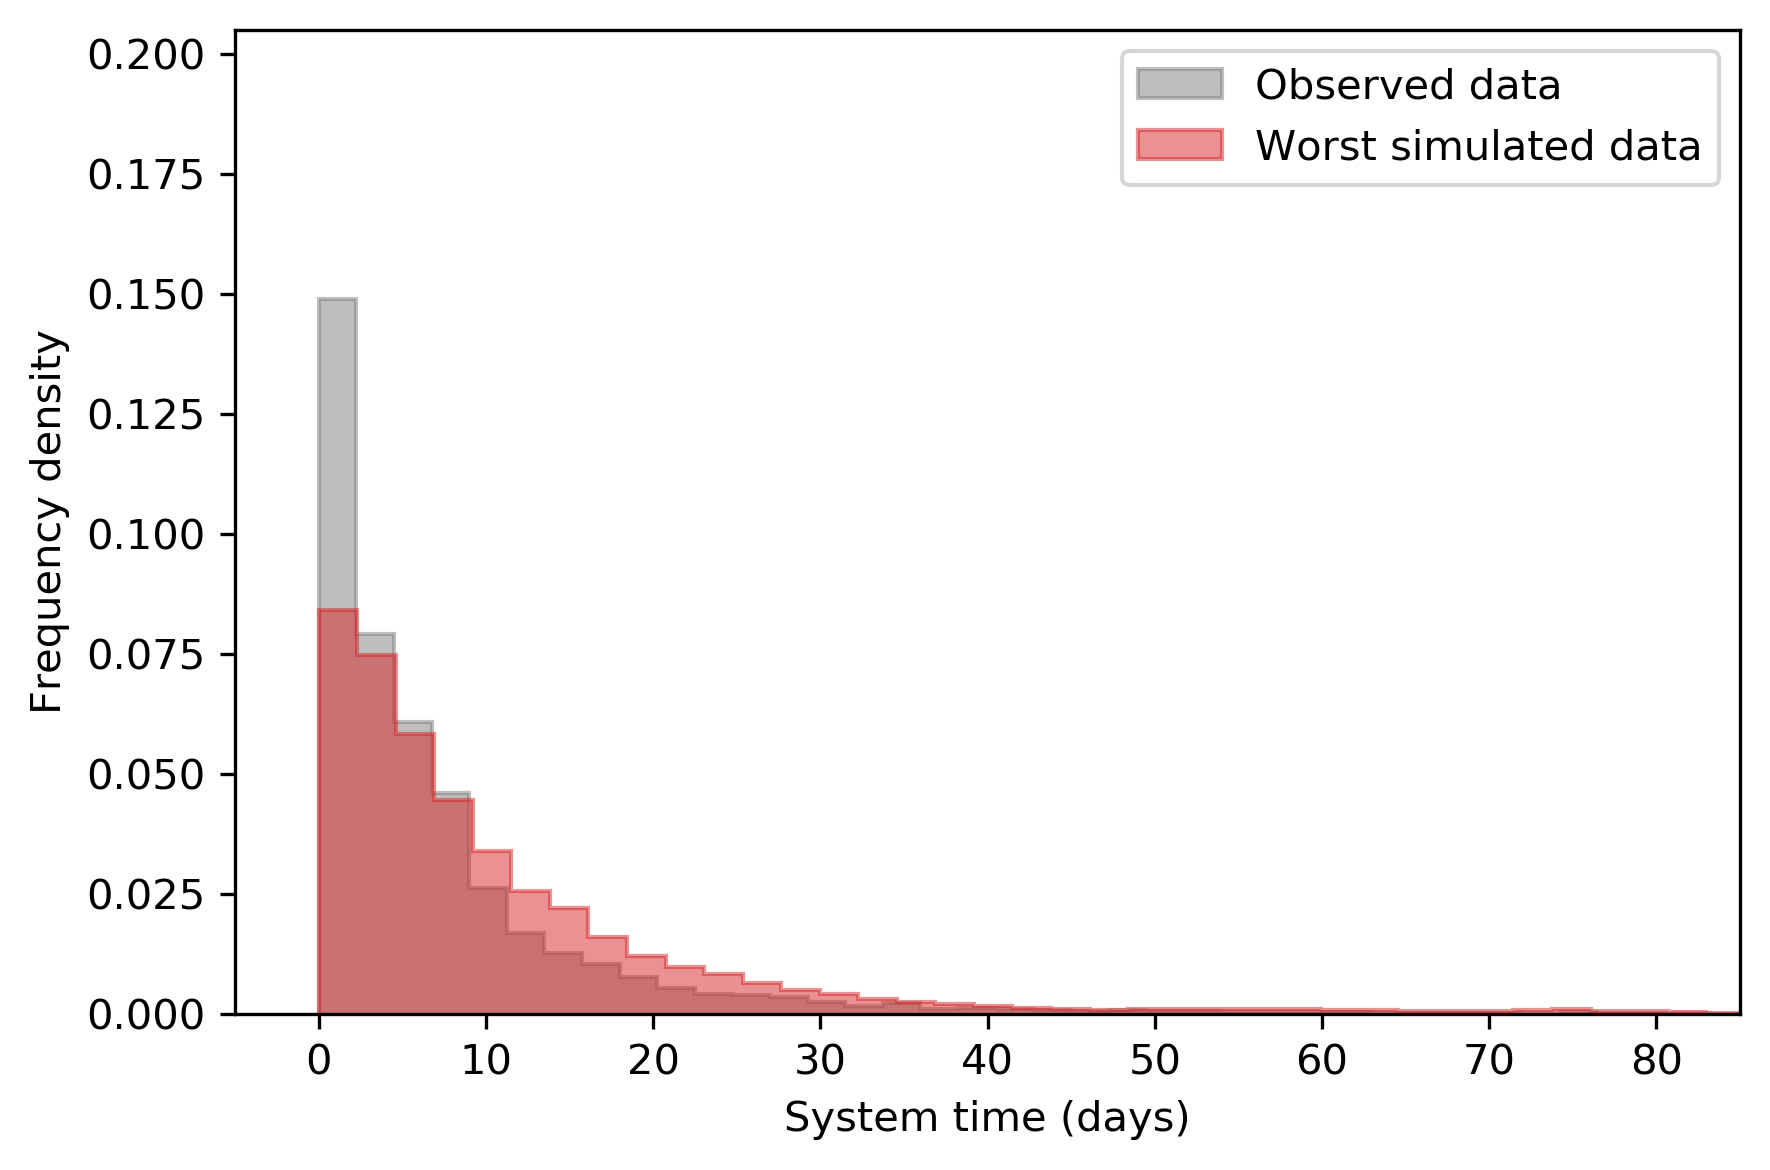

In [17]:
fig, ax = plt.subplots(dpi=300)

ax.hist(copd["true_los"], color="tab:gray", label="Observed data", **histkw)
ax.hist(
    worst_df["system_time"],
    color="tab:red",
    label="Worst simulated data",
    **histkw,
)

ax.set(
    xlim=(-5, 85),
    ylim=(0, 0.205),
    xlabel="System time (days)",
    ylabel="Frequency density",
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/worst_params.pdf", transparent=True)

In [18]:
describes = pd.concat(
    [
        values.describe().iloc[1:]
        for values in [
            copd["true_los"],
            best_df["system_time"],
            median_df["system_time"],
            worst_df["system_time"],
        ]
    ],
    axis=1,
).round(2)

describes.columns = [
    "Observed",
    "Best simulated",
    "Median simulated",
    "Worst simulated",
]
describes.index = ["Mean", "Std.", "Min.", "25%", "Med.", "75%", "Max."]

params = pd.DataFrame(
    {
        "Observed": [np.nan] * (len(best_ps) + 1) + [0],
        "Best simulated": [*best_ps, best_c, round(best_distance, 2)],
        "Median simulated": [*median_ps, median_c, round(median_distance, 2)],
        "Worst simulated": [*worst_ps, worst_c, round(worst_distance, 2)],
    },
    index=[
        "\(p_0\)",
        "\(p_1\)",
        "\(p_2\)",
        "\(p_3\)",
        "\(c\)",
        "Max. distance",
    ],
)

to_latex = pd.concat((params, describes))

to_latex.index = pd.MultiIndex.from_tuples(
    [
        *[("Model characteristic", i) for i in params.index],
        *[("LOS statistic", i) for i in describes.index],
    ]
)

string = (
    to_latex.to_latex(bold_rows=True)
    .replace("\\textbackslash ", "\\")
    .replace("\\_", "_")
)
with open("../tex/comparison.tex", "w") as f:
    f.write(string)

to_latex

Observed  Best simulated  \
Model characteristic \(p_0\)             NaN            0.80   
                     \(p_1\)             NaN            1.00   
                     \(p_2\)             NaN            1.00   
                     \(p_3\)             NaN            0.85   
                     \(c\)               NaN           35.00   
                     Max. distance      0.00            0.68   
LOS statistic        Mean               7.70            7.56   
                     Std.              11.86           11.44   
                     Min.               0.00            0.00   
                     25%                1.49            1.60   
                     Med.               4.20            3.90   
                     75%                8.93            8.81   
                     Max.             224.93          219.92   

                                    Median simulated  Worst simulated  
Model characteristic \(p_0\)                    0.70             1.00  
                     \(p_1\)                    0.55             1.00  
                     \(p_2\)                    0.85             0.95  
                     \(p_3\)                    0.70             0.90  
                     \(c\)                     40.00            30.00  
                     Max. distance              1.95            44.25  
LOS statistic        Mean                       6.23            11.56  
                     Std.                      10.45            14.81  
                     Min.                       0.00             0.00  
                     25%                        1.16             3.00  
                     Med.                       2.90             6.90  
                     75%                        6.54            14.21  
                     Max.                     187.78           230.49

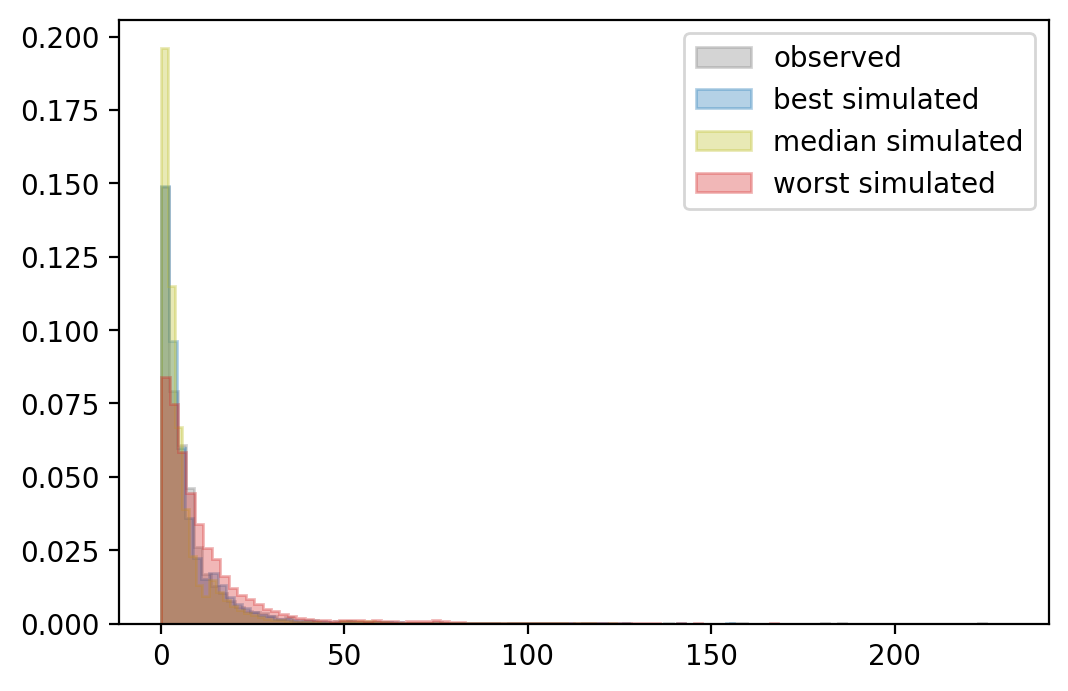

In [19]:
fig, ax = plt.subplots(dpi=200)

histkw = dict(bins=100, alpha=1 / 3, histtype="step", fill=True, density=True)

ax.hist(copd["true_los"], color="tab:gray", label="observed", **histkw)
ax.hist(
    best_df["system_time"], color="tab:blue", label="best simulated", **histkw
)
ax.hist(
    median_df["system_time"],
    color="tab:olive",
    label="median simulated",
    **histkw,
)
ax.hist(
    worst_df["system_time"], color="tab:red", label="worst simulated", **histkw
)

# ax.set(xlim=(-5, 65))
ax.legend()